In [2]:
import torch
print(torch.__version__)


2.5.1+cu124


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
# For handling Excel files
import openpyxl
# For progress bars
from tqdm.notebook import tqdm
# Setting plot style
sns.set(style="whitegrid")
%matplotlib inline
import glob
import shutil
import random
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [4]:
# Define the base directory
base_dir = 'E:/COVID-19_Radiography_Dataset'

# List all files and directories in the base directory
print("Contents of the base directory:")
print(os.listdir(base_dir))

Contents of the base directory:
['COVID', 'COVID.metadata.xlsx', 'Lung_Opacity', 'Lung_Opacity.metadata.xlsx', 'Normal', 'Normal.metadata.xlsx', 'README.md.txt', 'Viral Pneumonia', 'Viral Pneumonia.metadata.xlsx']


In [5]:
# Find all metadata files in the base directory
metadata_files = glob.glob(os.path.join(base_dir, '*.metadata.xlsx'))

print("\nFound Metadata Files:")
for file in metadata_files:
    print(os.path.basename(file))


Found Metadata Files:
COVID.metadata.xlsx
Lung_Opacity.metadata.xlsx
Normal.metadata.xlsx
Viral Pneumonia.metadata.xlsx


In [6]:
root_dir = 'E:/COVID-19_Radiography_Dataset'

classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Initialize a dictionary to hold metadata DataFrames
metadata = {}

for cls in classes:
    # Special case for 'Viral Pneumonia'
    if cls == 'Viral Pneumonia':
        metadata_path = os.path.join(root_dir, 'Viral Pneumonia.metadata.xlsx')
    else:
        metadata_path = os.path.join(root_dir, f'{cls}.metadata.xlsx')
        
    if os.path.exists(metadata_path):
        metadata_df = pd.read_excel(metadata_path)
        metadata[cls] = metadata_df
        print(f"Loaded metadata for class: {cls} with {len(metadata_df)} entries.")
    else:
        print(f"Metadata file for class {cls} not found at {metadata_path}.")

Loaded metadata for class: COVID with 3616 entries.
Loaded metadata for class: Lung_Opacity with 6012 entries.
Loaded metadata for class: Normal with 10192 entries.
Loaded metadata for class: Viral Pneumonia with 1345 entries.


In [7]:
# Inspect columns for each metadata DataFrame
for cls in classes:
    if cls in metadata:
        print(f"\nColumns in {cls} Metadata:")
        print(metadata[cls].columns)


Columns in COVID Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')

Columns in Lung_Opacity Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')

Columns in Normal Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')

Columns in Viral Pneumonia Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')


In [8]:
# Define the root directory of the dataset
root_dir = 'E:/COVID-19_Radiography_Dataset'

# Define class names
classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Define label indices
label_mapping = {cls: idx for idx, cls in enumerate(classes)}

In [9]:
# Initialize a list to hold all mapped data
all_mapped_data = []

# Iterate through each class and map images to their labels
for cls in classes:
    images_dir = os.path.join(root_dir, cls, 'images')
    
    # List all image filenames
    image_filenames = os.listdir(images_dir)
    
    for img_filename in image_filenames:
        img_path = os.path.join(images_dir, img_filename)
        
        # Append the image path and label to the mapped data list
        all_mapped_data.append((img_path, label_mapping[cls]))

# Optionally, print the mapped data
for img_path, label in all_mapped_data:
    print(f"Image Path: {img_path}, Label: {label}")


Image Path: E:/COVID-19_Radiography_Dataset\COVID\images\COVID-1.png, Label: 0
Image Path: E:/COVID-19_Radiography_Dataset\COVID\images\COVID-10.png, Label: 0
Image Path: E:/COVID-19_Radiography_Dataset\COVID\images\COVID-100.png, Label: 0
Image Path: E:/COVID-19_Radiography_Dataset\COVID\images\COVID-1000.png, Label: 0
Image Path: E:/COVID-19_Radiography_Dataset\COVID\images\COVID-1001.png, Label: 0
Image Path: E:/COVID-19_Radiography_Dataset\COVID\images\COVID-1002.png, Label: 0
Image Path: E:/COVID-19_Radiography_Dataset\COVID\images\COVID-1003.png, Label: 0
Image Path: E:/COVID-19_Radiography_Dataset\COVID\images\COVID-1004.png, Label: 0
Image Path: E:/COVID-19_Radiography_Dataset\COVID\images\COVID-1005.png, Label: 0
Image Path: E:/COVID-19_Radiography_Dataset\COVID\images\COVID-1006.png, Label: 0
Image Path: E:/COVID-19_Radiography_Dataset\COVID\images\COVID-1007.png, Label: 0
Image Path: E:/COVID-19_Radiography_Dataset\COVID\images\COVID-1008.png, Label: 0
Image Path: E:/COVID-1

In [10]:
# Initialize a dictionary to hold the counts for each label
label_counts = {label: 0 for label in label_mapping.values()}

# Iterate through the mapped data and count images per label
for img_path, label in all_mapped_data:
    if label in label_counts:
        label_counts[label] += 1

# Print the counts for each label
for label, count in label_counts.items():
    print(f"{label}: {count} images")

0: 3616 images
1: 6012 images
2: 10192 images
3: 1345 images


In [11]:
# Convert to DataFrame for easier inspection (without mask paths)
mapped_df = pd.DataFrame(all_mapped_data, columns=['image_path', 'label'])

# Display the first few entries
print("Mapped DataFrame:")
display(mapped_df.head())

# Check total number of mapped samples
print(f"Total images mapped: {len(mapped_df)}")

Mapped DataFrame:


,image_path,label
0,E:/COVID-19_Radiography_Dataset\COVID\images\C...,0
1,E:/COVID-19_Radiography_Dataset\COVID\images\C...,0
2,E:/COVID-19_Radiography_Dataset\COVID\images\C...,0
3,E:/COVID-19_Radiography_Dataset\COVID\images\C...,0
4,E:/COVID-19_Radiography_Dataset\COVID\images\C...,0


Total images mapped: 21165


In [12]:
# Print label mapping
print("Label Mapping (Class Name to Label):")
for class_name, label in label_mapping.items():
    print(f"{class_name}: {label}")

Label Mapping (Class Name to Label):
COVID: 0
Lung_Opacity: 1
Normal: 2
Viral Pneumonia: 3


In [13]:
# Count occurrences of each label
label_counts = mapped_df['label'].value_counts()

# Calculate the total number of samples
total_samples = len(mapped_df)

# Calculate the ratio of each class
class_ratios = label_counts / total_samples

# Print the ratios
print("Class Ratios:")
for class_name, ratio in class_ratios.items():
    print(f"{class_name}: {ratio:.2f} (or {ratio * 100:.2f}%)")


Class Ratios:
2: 0.48 (or 48.15%)
1: 0.28 (or 28.41%)
0: 0.17 (or 17.08%)
3: 0.06 (or 6.35%)


In [14]:
# Initialize a dictionary to hold subfolder names for each class
subfolder_dict = {}

# List all class folders
class_folders = os.listdir(base_dir)

# Check for subfolders in each class folder
print("Subfolders in each class folder:")
for class_folder in class_folders:
    class_path = os.path.join(base_dir, class_folder)
    if os.path.isdir(class_path):  # Check if it's a directory
        subfolders = [entry for entry in os.listdir(class_path) if os.path.isdir(os.path.join(class_path, entry))]
        if subfolders:  # Check if there are any subfolders
            subfolder_dict[class_folder] = subfolders
        else:
            subfolder_dict[class_folder] = "No subfolders"

# Print the subfolders found for each class
for class_name, subfolders in subfolder_dict.items():
    print(f"{class_name}: {subfolders}")

Subfolders in each class folder:
COVID: ['images']
Lung_Opacity: ['images']
Normal: ['images']
Viral Pneumonia: ['images']


In [15]:
import os
import shutil
import random
import pandas as pd

# Define source directory and working directory
source_dir = 'E:/COVID-19_Radiography_Dataset'  # Change as needed
working_dir = 'E:/selected_images'  # Your working directory

# Create the working directory if it doesn't exist
os.makedirs(working_dir, exist_ok=True)

# Define class names and their respective ratios
class_ratios = {
    'Normal': 0.4815,  # 48.15%
    'Lung_Opacity': 0.2841,  # 28.41%
    'COVID': 0.1708,  # 17.08%
    'Viral Pneumonia': 0.0635  # 6.35%
}

# Define the label mapping
label_mapping = {
    'COVID': 0,
    'Lung_Opacity': 1,
    'Normal': 2,
    'Viral Pneumonia': 3
}

# Calculate the number of samples for each class
total_samples = 1700
class_samples = {cls: int(total_samples * ratio) for cls, ratio in class_ratios.items()}

# Initialize a list to hold the copied image paths and their numeric labels
copied_images = []

# Copy images based on the calculated class samples
for cls, num_samples in class_samples.items():
    images_dir = os.path.join(source_dir, cls, 'images')
    all_images = os.listdir(images_dir)
    
    # Randomly select images if there are more than needed
    selected_images = random.sample(all_images, min(num_samples, len(all_images)))
    
    # Create a subfolder for the class in the working directory
    class_working_dir = os.path.join(working_dir, cls)
    os.makedirs(class_working_dir, exist_ok=True)
    
    for img_filename in selected_images:
        src_img_path = os.path.join(images_dir, img_filename)
        dst_img_path = os.path.join(class_working_dir, img_filename)  # Save to class subfolder in working directory
        shutil.copy(src_img_path, dst_img_path)
        copied_images.append((dst_img_path, label_mapping[cls]))  # Only keep track of copied images with numeric labels

# Create a DataFrame for the copied images and their numeric labels
mapped_df_samples = pd.DataFrame(copied_images, columns=['image_path', 'label'])

# Display the DataFrame showing the paths and numeric labels of the images
print("Copied Image Paths and Numeric Labels:")
display(mapped_df_samples)

# Optionally, show the count of copied images per class
for cls, count in class_samples.items():
    actual_count = mapped_df_samples['label'].value_counts().get(label_mapping[cls], 0)
    print(f"Copied {actual_count} images for class '{cls}' (Requested: {count})")


Copied Image Paths and Numeric Labels:


,image_path,label
0,E:/selected_images\Normal\Normal-8331.png,2
1,E:/selected_images\Normal\Normal-9037.png,2
2,E:/selected_images\Normal\Normal-5456.png,2
3,E:/selected_images\Normal\Normal-9923.png,2
4,E:/selected_images\Normal\Normal-5485.png,2
...,...,...
1692,E:/selected_images\Viral Pneumonia\Viral Pneum...,3
1693,E:/selected_images\Viral Pneumonia\Viral Pneum...,3
1694,E:/selected_images\Viral Pneumonia\Viral Pneum...,3
1695,E:/selected_images\Viral Pneumonia\Viral Pneum...,3


Copied 818 images for class 'Normal' (Requested: 818)
Copied 482 images for class 'Lung_Opacity' (Requested: 482)
Copied 290 images for class 'COVID' (Requested: 290)
Copied 107 images for class 'Viral Pneumonia' (Requested: 107)


In [16]:
import os
from PIL import Image
from torch.utils.data import Dataset

class COVID19RadiographyDataset(Dataset):
    def __init__(self, image_label_pairs, transform=None):
        """
        Args:
            image_label_pairs (list of tuples): List where each tuple contains (image_path, label).
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_label_pairs = image_label_pairs
        self.transform = transform

    def __len__(self):
        return len(self.image_label_pairs)

    def __getitem__(self, idx):
        image_path, label = self.image_label_pairs[idx]
        
        # Load image
        image = Image.open(image_path).convert('RGB')  # Ensure 3 channels
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label  # Return only image and label

In [17]:
from torchvision import transforms

# Define image transformations for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

# Define image transformations for validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [18]:
# Shuffle the data
from sklearn.model_selection import train_test_split

# Define split ratios
train_ratio = 0.8
test_ratio = 0.2  # The total split must sum to 1

# Perform the train-test split
train_data, test_data = train_test_split(
    copied_images,
    test_size=test_ratio,
    random_state=42,
    stratify=[x[1] for x in copied_images]  # Stratify based on labels
)
train_paths = train_data
# Output the sizes of the resulting datasets
print(f"Total samples: {len(copied_images)}")
print(f"Training samples: {len(train_data)}")
print(f"Testing samples: {len(test_data)}")


Total samples: 1697
Training samples: 1357
Testing samples: 340


In [19]:
# Display some samples from the train_data
num_samples_to_display = 5  # Number of samples you want to display
print("Samples from training data:")
for i in range(min(num_samples_to_display, len(train_data))):
    image_path, label = train_data[i]
    print(f"Sample {i + 1}:")
    print(f"  Image Path: {image_path}")
    print(f"  Label: {label}")


Samples from training data:
Sample 1:
  Image Path: E:/selected_images\COVID\COVID-3173.png
  Label: 0
Sample 2:
  Image Path: E:/selected_images\Normal\Normal-2652.png
  Label: 2
Sample 3:
  Image Path: E:/selected_images\Lung_Opacity\Lung_Opacity-2888.png
  Label: 1
Sample 4:
  Image Path: E:/selected_images\COVID\COVID-2727.png
  Label: 0
Sample 5:
  Image Path: E:/selected_images\COVID\COVID-127.png
  Label: 0


In [20]:
from sklearn.utils.class_weight import compute_class_weight
# Extract labels from training data
train_labels = [sample[1] for sample in train_data]

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float)
print(f"Class Weights: {class_weights}")

Class Weights: tensor([1.4623, 0.8812, 0.5187, 3.9448])


C:\Users\Asus\AppData\Local\Temp\ipykernel_30584\4171928423.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=train_label_counts.values, palette='viridis')


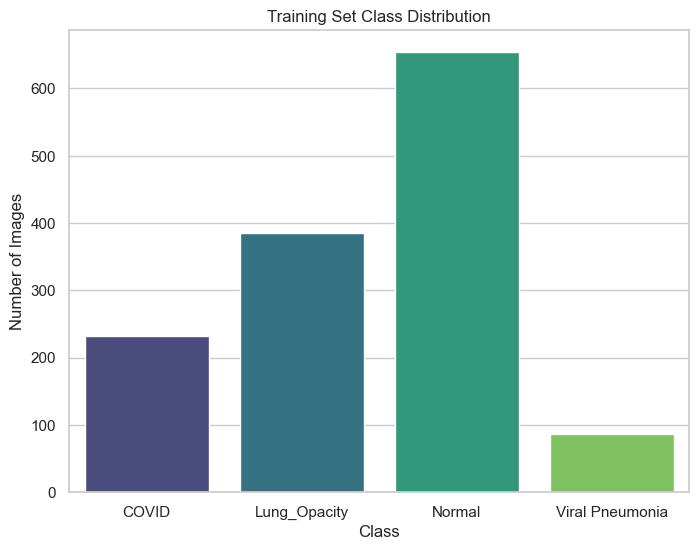

In [21]:
# Count class distribution in training set
train_label_counts = pd.Series(train_labels).value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(8,6))
sns.barplot(x=classes, y=train_label_counts.values, palette='viridis')
plt.title('Training Set Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

In [22]:
%pip install efficientnet-pytorch

  Using cached efficientnet_pytorch-0.7.1-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet

In [24]:
class EfficientNetB7Baseline(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetB7Baseline, self).__init__()
        # Initialize EfficientNetB7 model without pre-trained weights
        self.efficientnet = EfficientNet.from_name('efficientnet-b7', num_classes=num_classes)

    def forward(self, x):
        return self.efficientnet(x)

In [25]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [26]:
class EfficientNetB7WithSE(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetB7WithSE, self).__init__()
        # Initialize EfficientNetB7 model without pre-trained weights
        self.efficientnet = EfficientNet.from_name('efficientnet-b7', num_classes=num_classes)
        
        # Define an SE block
        self.se = SEBlock(channel=1536, reduction=16)  # EfficientNetB7's final block has 1536 channels

    def forward(self, x):
        # Forward through EfficientNetB7WithSE
        x = self.efficientnet.extract_features(x)  # Get features from EfficientNetB7
        x = self.se(x)  # Apply SE block
        x = self.efficientnet._avg_pooling(x)  # Average pooling
        x = torch.flatten(x, 1)  # Flatten the output
        x = self.efficientnet._dropout(x)  # Apply dropout
        x = self.efficientnet._fc(x)  # Final fully connected layer
        return x

In [27]:
# Choose model type
model_type = 'baseline'  # Options: 'baseline', 'se'

num_classes = len(classes)

if model_type == 'baseline':
    model = EfficientNetB7Baseline(num_classes=num_classes)  # Use baseline EfficientNetB7
elif model_type == 'se':
    model = EfficientNetB7WithSE(num_classes=num_classes)  # Use EfficientNetB7 with SE block
else:
    raise ValueError("Invalid model type selected.")

# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(model)

EfficientNetB7Baseline(
  (efficientnet): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          64, 16, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          16, 64, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2

In [29]:
# Define loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [38]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs):
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=phase.capitalize()):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        print()
    
    print(f'Best Validation Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [ ]:
from sklearn.model_selection import KFold
import torch.optim as optim
import numpy as np

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")


# Define hyperparameters to tune
batch_sizes = [16, 32]
learning_rates = [1e-3, 1e-4]
num_epochs = 10  # Set number of epochs for training
num_workers = 0

# Define 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store best model and associated hyperparameters per fold
best_fold_accuracies = []
best_fold_params = []

# Loop over each fold in cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(train_paths), 1):
    print(f"\nStarting fold {fold}...")
    
    # Split data for this fold
    train_data = [train_paths[i] for i in train_index]
    val_data = [train_paths[i] for i in val_index]
    
    # Create dataset and loaders for this fold
    train_dataset = COVID19RadiographyDataset(train_data, transform=train_transform)
    val_dataset = COVID19RadiographyDataset(val_data, transform=val_test_transform)
    
    # Track best accuracy and parameters for this fold
    best_acc = 0.0
    best_params = {}
    
    for batch_size in batch_sizes:
        for lr in learning_rates:
            print(f"\nTesting batch size: {batch_size}, learning rate: {lr}")
            
            # Data loaders for this hyperparameter setting
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
            
            # Initialize the model, criterion, optimizer, and scheduler for this setting
            model = EfficientNetB7WithSE(num_classes=num_classes) if model_type == 'se' else EfficientNetB7Baseline(num_classes=num_classes)
            model = model.to(device)
            criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
            optimizer = optim.Adam(model.parameters(), lr=lr)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
            
            # Train model for this fold with current hyperparameters
            trained_model, history = train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs)
            
            # Record best validation accuracy for this setting
            fold_best_acc = max(history['val_acc'])
            print(f"Fold {fold}, batch size {batch_size}, learning rate {lr}: Best validation accuracy = {fold_best_acc:.4f}")
            
            # Update best parameters if current accuracy is higher for this fold
            if fold_best_acc > best_acc:
                best_acc = fold_best_acc
                best_params = {
                    'batch_size': batch_size,
                    'learning_rate': lr,
                }
    
    # Store best accuracy and hyperparameters for this fold
    best_fold_accuracies.append(best_acc)
    best_fold_params.append(best_params)
    print(f"Best parameters for fold {fold}: {best_params} with accuracy: {best_acc:.4f}")

# Overall best parameters and average accuracy across folds
overall_best_accuracy = np.mean(best_fold_accuracies)
print(f"\nAverage best accuracy across folds: {overall_best_accuracy:.4f}")
print(f"Best parameters per fold: {best_fold_params}")


Using device: cuda
GPU: NVIDIA GeForce RTX 3060

Starting fold 1...

Testing batch size: 16, learning rate: 0.001
Epoch 1/10
----------


Train:   0%|          | 0/68 [00:00<?, ?it/s]

Train Loss: 1.4781 Acc: 0.2737


Val:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.4240 Acc: 0.1324

Epoch 2/10
----------


Train:   0%|          | 0/68 [00:00<?, ?it/s]

Train Loss: 1.4199 Acc: 0.2461


Val:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.4255 Acc: 0.1324

Epoch 3/10
----------


Train:   0%|          | 0/68 [00:00<?, ?it/s]

Train Loss: 1.3703 Acc: 0.2157


Val:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.3944 Acc: 0.3125

Epoch 4/10
----------


Train:   0%|          | 0/68 [00:00<?, ?it/s]

Train Loss: 1.3243 Acc: 0.2747


Val:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.3965 Acc: 0.3125

Epoch 5/10
----------


Train:   0%|          | 0/68 [00:00<?, ?it/s]

Train Loss: 1.3493 Acc: 0.2894


Val:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.5080 Acc: 0.0699

Epoch 6/10
----------


Train:   0%|          | 0/68 [00:00<?, ?it/s]

Train Loss: 1.2810 Acc: 0.2940


Val:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.5214 Acc: 0.1324

Epoch 7/10
----------


Train:   0%|          | 0/68 [00:00<?, ?it/s]

Train Loss: 1.2787 Acc: 0.3014


Val:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.3590 Acc: 0.3566

Epoch 8/10
----------


Train:   0%|          | 0/68 [00:00<?, ?it/s]

Train Loss: 1.2178 Acc: 0.2903


Val:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.3880 Acc: 0.1397

Epoch 9/10
----------


Train:   0%|          | 0/68 [00:00<?, ?it/s]

Train Loss: 1.2211 Acc: 0.2848


Val:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.4832 Acc: 0.1985

Epoch 10/10
----------


Train:   0%|          | 0/68 [00:00<?, ?it/s]

Train Loss: 1.2079 Acc: 0.3410


Val:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.1795 Acc: 0.4596

Best Validation Acc: 0.4596
Fold 1, batch size 16, learning rate 0.001: Best validation accuracy = 0.4596

Testing batch size: 16, learning rate: 0.0001
Epoch 1/10
----------


Train:   0%|          | 0/68 [00:00<?, ?it/s]

Train Loss: 1.4624 Acc: 0.2866


Val:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.3890 Acc: 0.1324

Epoch 2/10
----------


Train:   0%|          | 0/68 [00:00<?, ?it/s]

Train Loss: 1.4165 Acc: 0.2894


Val:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.3897 Acc: 0.3125

Epoch 3/10
----------


Train:   0%|          | 0/68 [00:00<?, ?it/s]

Train Loss: 1.4629 Acc: 0.3198


Val:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.3896 Acc: 0.3125

Epoch 4/10
----------


Train:   0%|          | 0/68 [00:00<?, ?it/s]

Train Loss: 1.4016 Acc: 0.3493


Val:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.3949 Acc: 0.3125

Epoch 5/10
----------


Train:   0%|          | 0/68 [00:00<?, ?it/s]

Train Loss: 1.3780 Acc: 0.3539


Val:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.3923 Acc: 0.3125

Epoch 6/10
----------


Train:   0%|          | 0/68 [00:00<?, ?it/s]

Train Loss: 1.3757 Acc: 0.3475


Val:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.3914 Acc: 0.1324

Epoch 7/10
----------


Train:   0%|          | 0/68 [00:00<?, ?it/s]

Train Loss: 1.3449 Acc: 0.3548


Val:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.4028 Acc: 0.1287

Epoch 8/10
----------


Train:   0%|          | 0/68 [00:00<?, ?it/s]

Train Loss: 1.2716 Acc: 0.3429


Val:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.4385 Acc: 0.0699

Epoch 9/10
----------


Train:   0%|          | 0/68 [00:00<?, ?it/s]

Train Loss: 1.2124 Acc: 0.4028


Val:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.2222 Acc: 0.2757

Epoch 10/10
----------


Train:   0%|          | 0/68 [00:00<?, ?it/s]

Train Loss: 1.1727 Acc: 0.3834


Val:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.8859 Acc: 0.1875

Best Validation Acc: 0.3125
Fold 1, batch size 16, learning rate 0.0001: Best validation accuracy = 0.3125

Testing batch size: 32, learning rate: 0.001
Epoch 1/10
----------


Train:   0%|          | 0/34 [00:00<?, ?it/s]

In [ ]:
full_train_dataset = COVID19RadiographyDataset(train_paths, transform=train_transform)
full_train_loader = DataLoader(full_train_dataset, batch_size=best_hyperparams['batch_size'], shuffle=True, num_workers=num_workers)

# Initialize the model, criterion, optimizer, and scheduler with the best parameters
final_model = EfficientNetB7WithSE(num_classes=num_classes) if model_type == 'se' else EfficientNetB7Baseline(num_classes=num_classes)
final_model = final_model.to(device)
final_criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
final_optimizer = optim.Adam(final_model.parameters(), lr=best_hyperparams['learning_rate'])
final_scheduler = optim.lr_scheduler.StepLR(final_optimizer, step_size=10, gamma=0.1)

# Train the model on the full dataset
final_trained_model, final_history = train_model(final_model, final_criterion, final_optimizer, final_scheduler, full_train_loader, None, num_epochs=num_epochs)

print("\nTraining completed on the full dataset.")

In [ ]:
# Define evaluation function
def evaluate_model(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Create dataset and dataloader for the test dataset
test_dataset = COVID19RadiographyDataset(test_paths, transform=val_test_transform)  
test_loader = DataLoader(test_dataset, batch_size=best_hyperparams['batch_size'], shuffle=False, num_workers=num_workers)

# Evaluate the model on the test dataset
evaluate_model(final_trained_model, test_loader, classes)

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Check if history contains the necessary keys
    if not all(key in history for key in ['train_loss', 'val_loss', 'train_acc', 'val_acc']):
        raise KeyError("History must contain keys: 'train_loss', 'val_loss', 'train_acc', 'val_acc'.")

    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history)